# Look at the results of the Jet Or Not workflow
## Need: question_reducer_jet_or_not.csv, question_extractor_trimmed.csv
This jupyter notebook plots the results of the Jet or No question, it calculates and looks at the agreement of the subjects. We prefer a high agreement score since then the volunteers give the same answer on one subject.   
We also look at the number of votes per subject, do we see many deviations from the retirment limit set? Why do we expect that is happening? Are the beta classifactions giving us mixed results?   
This notebook contains the analysis for the first launch of the 2011-2013 data, however this can be repeated for other years to make sure the results are right. You can use the tools of this notebook to   
analyse the later data. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import os
from skimage import io
from panoptes_client import Panoptes, Subject, Workflow
from dateutil.parser import parse
import getpass
import subprocess
%matplotlib inline

Broken libmagic installation detected. The python-magic module is installed but can't be imported. Please check that both python-magic and the libmagic shared library are installed correctly. Uploading media other than images may not work.


In [3]:
# connect to the panoptes client
username = getpass.getpass('Username: ')
password = getpass.getpass('Password: ')
Panoptes.connect(username=username, password=password)

Username:  ·········
Password:  ············


Load in the reducer data and parse the columns

In [18]:
from aggregation import QuestionResult
data = ascii.read('reductions/question_reducer_jet_or_not.csv', format='csv')
print(f"Number of subjects: {len(data)}")

# change the columns to make it easier to work with
data.rename_column('data.no-there-are-no-jets-in-this-image-sequence', 'data.no')
data.rename_column('data.yes-there-is-at-least-one-jet-in-this-image-sequence', 'data.yes')

# initiate the filled data set as a class
data_object = QuestionResult(data)


Number of subjects: 3961


We need to calculate the aggregated agreement value, which we define as the one have the maximum votes for a given subject. Edge cases (50% yes, 50% no) are not handled here. We'll also calculate how many classifications each subject received. 

In [19]:
# Calculate the agreement
agreement, jet_mask, non_jet_mask, Ans = data_object.Agr_mask()
print(agreement.min(), agreement.max(), agreement.mean())

0.5 1.0 0.8523628331154955


Looks like we have a good agreement fraction. The mean agreement is greater than 85%, so that means most subjects were handled easily. Let's check statistics on vote count:

In [20]:
num_votes = np.asarray(data['data.no']) + np.asarray(data['data.yes'])


In [21]:
print(num_votes.min(), num_votes.max())

1.0 51.0


The workflow has been completed so not sure why we are seeing vote count of 1. What subjects do these correspond to?

In [22]:
unretired_subjects = data['subject_id'][num_votes<3]

for subject in unretired_subjects:
    panoptes_subject = Subject(subject)
    subject_mask = data['subject_id']==subject
    print(f"Subject ID: {subject} subject sets: {panoptes_subject.raw['links']['subject_sets']} # votes: {num_votes[subject_mask][0]}  yes: {data['data.yes'][subject_mask][0]} no: {data['data.no'][subject_mask][0]}" )

Subject ID: 62834011 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834012 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834019 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834021 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834024 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834025 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834033 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834035 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834036 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834038 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834046 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834059 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834062 subject sets: ['95940'] # votes: 1.0  yes: -- no: 1.0
Subject ID: 62834065 subj

Looks like mostly beta except for the last one... Let's look at that one

In [23]:
subject_unretired = Subject(70443867)
nframes = len(subject_unretired.raw['locations'])
subject_unretired.subject_workflow_status(18563).raw['retired_at'] 

'2021-12-08T23:10:45.228Z'

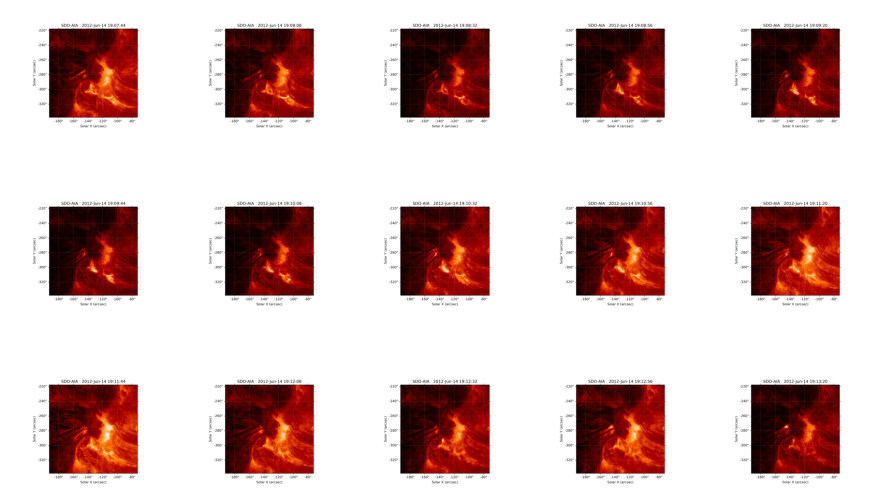

In [26]:
fig, axs = plt.subplots(3, 5, dpi=150, sharex=True, sharey=True)

for i in range(nframes):
    url = subject_unretired.raw['locations'][i]['image/png']
    img = io.imread(url)
    #plt.imsave('frame_%d.png'%i, img)
    axs[i//5,i%5].imshow(img)
    axs[i//5,i%5].axis('off')
    
plt.tight_layout()
plt.show()

In [18]:
all_extraction_data = ascii.read('question_extractor_trimmed.csv', format='csv')

# change the columns to make it easier to work with
all_extraction_data.rename_column('data.no-there-are-no-jets-in-this-image-sequence', 'data.no')
all_extraction_data.rename_column('data.yes-there-is-at-least-one-jet-in-this-image-sequence', 'data.yes')

# fill in missing data
all_extraction_data['data.yes'].fill_value = 0
all_extraction_data['data.no'].fill_value = 0

all_extraction_data = all_extraction_data.filled()

In [19]:
extractions_subject70443867 = all_extraction_data[:][all_extraction_data['subject_id']==70443867]
print(extractions_subject70443867['user_id','created_at','data.no','data.yes'])

 user_id         created_at       data.no data.yes
--------- ----------------------- ------- --------
    1e+20 2021-12-08 18:26:46 UTC     1.0      0.0
2377012.0 2021-12-08 20:12:46 UTC     1.0      0.0
    1e+20 2021-12-08 23:10:45 UTC     1.0      0.0


Ah, so this was three classifications, but the first and third were by the same user. So the reducer is skipping it. Now, onto more general statistics.

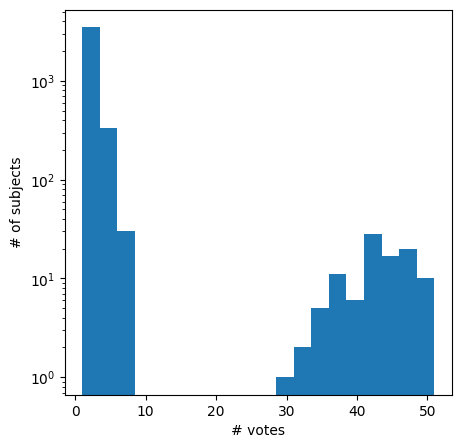

In [31]:
plt.style.use('default')

fig, axs = plt.subplots(1,1, figsize=(5,5), sharey=True)

# axs[0].hist(agreement*100, 20, range=(0,100))
# axs[0].set_xlabel('Agreement [%]')

axs.hist(num_votes, 20)
axs.set_xlabel('# votes')

axs.set_yscale('log')
# axs[1].set_yscale('log')

# axs[0].set_xlim((0, 100))

axs.set_ylabel("# of subjects")

plt.show()

In [21]:
print(f"% of subjects above 60%: {np.sum(agreement>0.6)/len(agreement)*100:.2f}")
print(f"% of subjects above 80%: {np.sum(agreement>0.8)/len(agreement)*100:.2f}")
print(f"% of subjects above 95%: {np.sum(agreement>0.95)/len(agreement)*100:.2f}")

% of subjects above 60%: 97.80
% of subjects above 80%: 56.30
% of subjects above 95%: 54.71


There's a bunch of classifications that have very high vote count. The retirement threshold for this dataset is 3 votes, so this is really strange. 

In [33]:
high_vote_count_mask = (num_votes>30)&(num_votes<40)
data_high_vote_count = data[:][high_vote_count_mask]
print(data_high_vote_count)

subject_id workflow_id task ... data.no data.aggregation_version data.yes
---------- ----------- ---- ... ------- ------------------------ --------
  70444786       18563   T0 ...     7.0                    3.6.0     30.0
  70444795       18563   T0 ...     9.0                    3.6.0     29.0
  70444807       18563   T0 ...    22.0                    3.6.0     17.0
  70444812       18563   T0 ...    17.0                    3.6.0     20.0
  70444814       18563   T0 ...    29.0                    3.6.0     10.0
  70444821       18563   T0 ...    30.0                    3.6.0      8.0
  70444824       18563   T0 ...    19.0                    3.6.0     15.0
  70444831       18563   T0 ...    28.0                    3.6.0      6.0
  70444841       18563   T0 ...    32.0                    3.6.0      1.0
  70444847       18563   T0 ...    27.0                    3.6.0      5.0
  70444848       18563   T0 ...    37.0                    3.6.0      1.0
  70444856       18563   T0 ...     4.

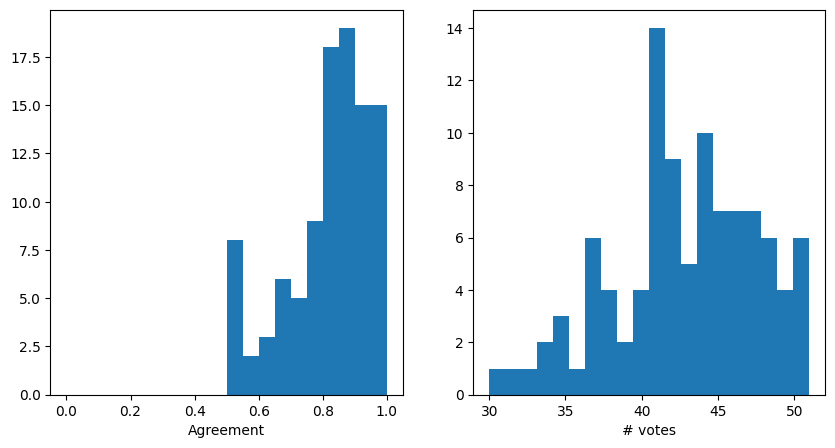

In [17]:
plt.style.use('default')

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].hist(agreement[high_vote_count_mask], 20, range=(0, 1))
axs[0].set_xlabel('Agreement')

axs[1].hist(num_votes[high_vote_count_mask], 20)
axs[1].set_xlabel('# votes')

# axs[0].set_yscale('log')
# axs[1].set_yscale('log')

plt.show()

These also have pretty high agreement scores. There's a peak at 50% though, so there's ~10 subjects that seem to be difficult. Let's load up the extraction data for these subjects and see when the classifications happened. Let's also look at whether these subjects were retired using the Panoptes client to make sure that this data is from the right things.

In [24]:
extraction_data = ascii.read('question_extractor_trimmed.csv', format='csv')

# change the columns to make it easier to work with
extraction_data.rename_column('data.no-there-are-no-jets-in-this-image-sequence', 'data.no')
extraction_data.rename_column('data.yes-there-is-at-least-one-jet-in-this-image-sequence', 'data.yes')

# fill in missing data
extraction_data['data.yes'].fill_value = 0
extraction_data['data.no'].fill_value = 0
extraction_data = extraction_data.filled()

In [28]:
time_after_retirement = []
for subject in data_high_vote_count['subject_id']:
    extracts = extraction_data[:][extraction_data['subject_id']==subject]
    extract_dates = [parse(datei) for datei in extracts['created_at']]
    panoptes_subject = Subject(subject)
    
    # find when this subject was uploaded
    upload_date = parse(panoptes_subject.raw['created_at'])
#     print(panoptes_subject.raw['links']['subject_sets'])
    retired = panoptes_subject.subject_workflow_status(18563).raw['retired_at'] 
    if retired is not None:
        retired = parse(retired)
        pre_retirement  = [datei < retired for datei in extract_dates]
        post_retirement = [datei >= retired for datei in extract_dates]
        time_after_retirement.extend([(datei-retired).seconds for datei in extract_dates if datei>=retired])
    else:
        print("not retired")
#     print(retired)
    retired_str = retired.strftime("%Y-%m-%d %H:%M:%S")
    upload_str  = upload_date.strftime("%Y-%m-%d %H:%M:%S")
    print(f"ID: {subject} uploaded at {upload_str} retired at {retired_str} # votes before: {np.sum(pre_retirement)} after: {np.sum(post_retirement)}. Subject sets: {panoptes_subject.raw['links']['subject_sets']}")

ID: 70444781 uploaded at 2021-11-24 13:11:30 retired at 2021-12-08 15:48:36 # votes before: 3 after: 58. Subject sets: ['99832', '100128']
ID: 70444786 uploaded at 2021-11-24 13:11:31 retired at 2021-12-08 12:52:51 # votes before: 3 after: 47. Subject sets: ['99832', '100128']
ID: 70444788 uploaded at 2021-11-24 13:11:31 retired at 2021-12-09 05:41:22 # votes before: 3 after: 48. Subject sets: ['99832', '100128']
ID: 70444789 uploaded at 2021-11-24 13:11:32 retired at 2021-12-09 03:48:35 # votes before: 3 after: 61. Subject sets: ['99832', '100128']
ID: 70444790 uploaded at 2021-11-24 13:11:32 retired at 2021-12-08 23:08:50 # votes before: 3 after: 62. Subject sets: ['99832', '100128']
ID: 70444791 uploaded at 2021-11-24 13:11:32 retired at 2021-12-08 12:20:30 # votes before: 3 after: 51. Subject sets: ['99832', '100128']
ID: 70444794 uploaded at 2021-11-24 13:11:33 retired at 2021-12-08 16:07:47 # votes before: 3 after: 55. Subject sets: ['99832', '100128']
ID: 70444795 uploaded at 20

So all the subjects are being retired correctly after 3 votes, but for some reason are still being shown to volunteers. These are also all from the 2012 data.

Now we'll look at the same statistics for low vote count (between 5-20). There are thousands of subjects with less than 5 classifications, so we'll limit it here.

In [20]:
low_vote_count_mask = (num_votes>=5)&(num_votes<20)
data_low_vote_count = data[:][low_vote_count_mask]
print(data_low_vote_count)

subject_id workflow_id task ... data.no data.aggregation_version data.yes
---------- ----------- ---- ... ------- ------------------------ --------
  70439041       18563   T0 ...     0.0                    3.6.0      6.0
  70439254       18563   T0 ...     5.0                    3.6.0      0.0
  70439274       18563   T0 ...     4.0                    3.6.0      1.0
  70439353       18563   T0 ...     4.0                    3.6.0      1.0
  70439384       18563   T0 ...     2.0                    3.6.0      3.0
  70439689       18563   T0 ...     3.0                    3.6.0      2.0
  70439891       18563   T0 ...     3.0                    3.6.0      2.0
  70439897       18563   T0 ...     0.0                    3.6.0      6.0
  70440305       18563   T0 ...     3.0                    3.6.0      2.0
  70440309       18563   T0 ...     4.0                    3.6.0      1.0
       ...         ...  ... ...     ...                      ...      ...
  70440829       18563   T0 ...     1.

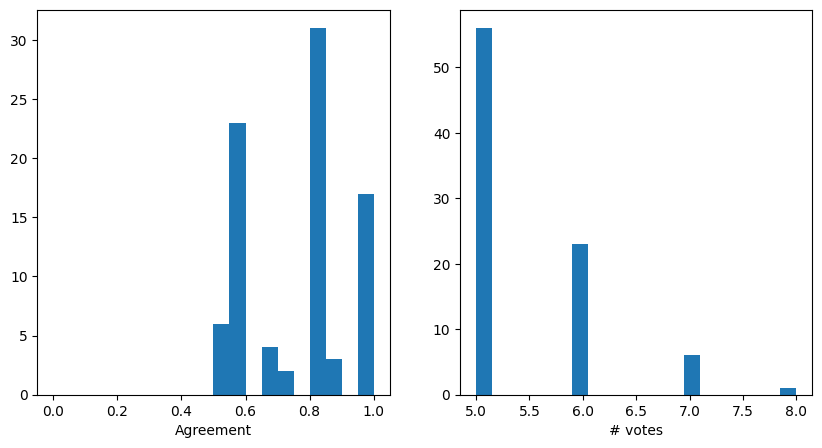

In [21]:
plt.style.use('default')

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].hist(agreement[low_vote_count_mask], 20, range=(0, 1))
axs[0].set_xlabel('Agreement')

axs[1].hist(num_votes[low_vote_count_mask], 20)
axs[1].set_xlabel('# votes')

# axs[0].set_yscale('log')
# axs[1].set_yscale('log')

plt.show()

In [22]:
time_after_retirement = []
for subject in data_low_vote_count['subject_id']:
    extracts = extraction_data[:][extraction_data['subject_id']==subject]
    extract_dates = [parse(datei) for datei in extracts['created_at']]
    panoptes_subject = Subject(subject)
#     print()
    retired = panoptes_subject.subject_workflow_status(18563).raw['retired_at'] 
    if retired is not None:
        retired = parse(retired)
        pre_retirement  = [datei < retired for datei in extract_dates]
        post_retirement = [datei >= retired for datei in extract_dates]
        time_after_retirement.extend([(datei-retired).seconds for datei in extract_dates if datei>=retired])
    else:
        print("not retired")
    retired_str = retired.strftime("%Y-%m-%d %H:%M:%S")
    print(f"ID: {subject} retired at {retired_str} # votes before: {np.sum(pre_retirement)} after: {np.sum(post_retirement)}. Subject sets: {panoptes_subject.raw['links']['subject_sets']}")

ID: 70439041 retired at 2021-12-08 00:48:13 # votes before: 3 after: 3. Subject sets: ['99831', '100128']
ID: 70439254 retired at 2021-12-08 00:33:01 # votes before: 3 after: 2. Subject sets: ['99831']
ID: 70439274 retired at 2021-12-08 00:37:52 # votes before: 3 after: 2. Subject sets: ['99831']
ID: 70439353 retired at 2021-12-08 00:42:12 # votes before: 3 after: 2. Subject sets: ['99831']
ID: 70439384 retired at 2021-12-08 00:47:06 # votes before: 3 after: 2. Subject sets: ['99831', '100128']
ID: 70439689 retired at 2021-12-08 00:23:40 # votes before: 3 after: 2. Subject sets: ['99831', '100128']
ID: 70439891 retired at 2021-12-08 00:33:59 # votes before: 3 after: 2. Subject sets: ['99831']
ID: 70439897 retired at 2021-12-08 00:31:20 # votes before: 3 after: 3. Subject sets: ['99831', '100128']
ID: 70440305 retired at 2021-12-08 00:37:55 # votes before: 3 after: 2. Subject sets: ['99831', '100128']
ID: 70440309 retired at 2021-12-07 23:32:03 # votes before: 3 after: 2. Subject sets: 

These are also being retired correctly, but they are all from the 2011 data, which is currently turned off in the lab. Maybe that's why they didn't get as many classifications, but that doesn't explain there's a huge divide in between 10 and 30 votes. 

Let's now look at high agreement score (>80%)

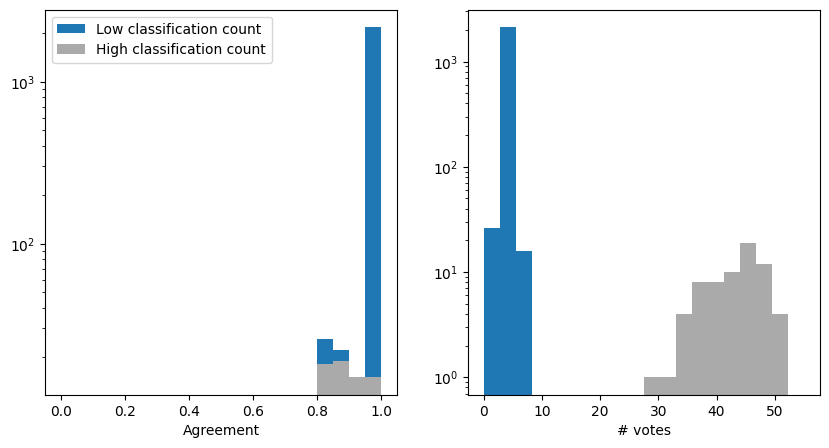

In [23]:
agreement80_mask = agreement>0.8

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].hist(agreement[agreement80_mask], 20, range=(0, 1), label='Low classification count')
axs[0].set_xlabel('Agreement')

axs[1].hist(num_votes[agreement80_mask], 20,  range=(0, 55))
axs[1].set_xlabel('# votes')

agreement80_high_vote_mask = (agreement>0.8)&(num_votes>20)

axs[0].hist(agreement[agreement80_high_vote_mask], 20, range=(0, 1), color='#aaa', label='High classification count')
axs[0].set_xlabel('Agreement')

axs[1].hist(num_votes[agreement80_high_vote_mask], 20, range=(0, 55), color='#aaa')
axs[1].set_xlabel('# votes')

axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].legend(loc='upper left')

plt.show()

66


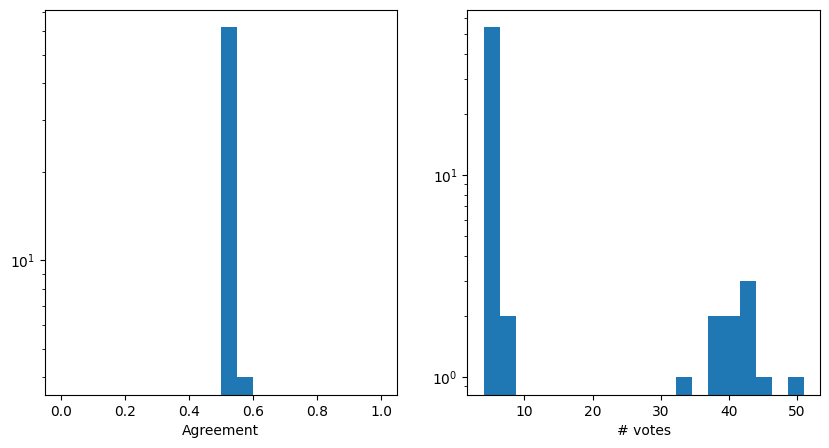

In [24]:
agreement60_mask = agreement<0.6

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].hist(agreement[agreement60_mask], 20, range=(0, 1))
axs[0].set_xlabel('Agreement')

axs[1].hist(num_votes[agreement60_mask], 20)
axs[1].set_xlabel('# votes')

axs[0].set_yscale('log')
axs[1].set_yscale('log')

print(sum(agreement60_mask))

plt.show()

Now let's look at specifically those that have jets in them (i.e. "yes" got more votes than "no").
First let's look at low agreement score data:

In [29]:
agreement60_jet_mask = (agreement<0.6)&(jet_mask)

subjects60  = data['subject_id'][agreement60_jet_mask]
agreement60 = agreement[agreement60_jet_mask]
count60     = num_votes[agreement60_jet_mask]
value60     = 1*[agreement60_jet_mask]

In [26]:
print(subjects60)
print(len(subjects60))

subject_id
----------
  70439091
  70439136
  70439293
  70439342
  70439418
  70439428
  70439434
  70439454
  70439517
  70439538
       ...
  70444812
  70444827
  70444857
  70444910
  70444927
  70444941
  70445874
  70446099
  70446107
  70446111
  70446129
Length = 60 rows
60


In [28]:
for i, subjecti in enumerate(subjects60):
    print("\r [%-40s] %d/%d"%(int(i/len(subjects60)*40)*'=', i+1, len(subjects60)), end='')
    subject = Subject(subjecti)
    locations = subject.raw['locations']
    
    # ignore this if the subject was not added to the new set
    if '100128' not in subject.raw['links']['subject_sets']:
        continue
#     print(subjecti)
    for j, locationi in enumerate(locations):
        if os.path.exists(f'agreement60_jet/{subjecti}/frame_{j}.png'):
            continue
        try:
            location = locationi['image/png']
        except KeyError:
            location = locationi['image/jpeg']
        except Exception as e:
            raise e
        img = io.imread(location)

        fig, axi = plt.subplots(1,1, dpi=150)

        axi.imshow(img)
        axi.axis('off')
        
        if not os.path.exists(f'agreement60_jet/{subjecti}/'):
            os.mkdir(f'agreement60_jet/{subjecti}/')

        axi.set_title(f'# votes: {count60[i]} agreement: {agreement60[i]:.2f}' )

        plt.savefig(f'agreement60_jet/{subjecti}/frame_{j}.png', facecolor='white', bbox_inches='tight')
        plt.close(fig)
        
# for i, subjecti in enumerate(subjects60):
    out = subprocess.run(f'ffmpeg -y -r 2 -i agreement60_jet/{subjecti}/frame_%d.png -vf "split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" agreement60_jet/{subjecti}.gif')
#     out = subprocess.run(f"ffmpeg -h", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     print(out.stderr)
                         
#     plt.show()

 [======================================= ] 60/60

In [29]:
agreement80_jet_mask = (agreement>0.8)&(jet_mask)

subjects80  = data['subject_id'][agreement80_jet_mask]
agreement80 = agreement[agreement80_jet_mask]
count80     = num_votes[agreement80_jet_mask]
value80     = 1*[agreement80_jet_mask]

print(len(subjects80))

540


In [ ]:
for i, subjecti in enumerate(subjects80):
#     print(subjecti)
    print("\r [%-40s] %d/%d  %d"%(int(i/len(subjects80)*40)*'=', i+1, len(subjects80), subjecti), end='')
    subject = Subject(subjecti)
    locations = subject.raw['locations']
    # ignore this if the subject was not added to the new set
    if '100128' not in subject.raw['links']['subject_sets']:
        continue
        
    # for now only plot the high vote count ones
    if count80[i] < 20:
        continue
        
    if not os.path.exists(f'agreement80_jet/{subjecti}/'):
        os.mkdir(f'agreement80_jet/{subjecti}/')
    
    for j, locationi in enumerate(locations):
#         if os.path.exists(f'agreement80_jet/{subjecti}/frame_{j}.png'):
#             continue
        try:
            location = locationi['image/png']
        except KeyError:
            location = locationi['image/jpeg']
        except Exception as e:
            raise e
        img = io.imread(location)

        fig, axi = plt.subplots(1,1, dpi=150)

        axi.imshow(img)
        axi.axis('off')
        
        axi.set_title(f'# votes: {count80[i]} agreement: {agreement80[i]:.2f}' )

        plt.savefig(f'agreement80_jet/{subjecti}/frame_{j}.png', facecolor='white', bbox_inches='tight')
        plt.close(fig)
        
# for i, subjecti in enumerate(subjects80):
    out = subprocess.run(f'ffmpeg -y -r 2 -i agreement80_jet/{subjecti}/frame_%d.png -vf "split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" agreement80_jet/{subjecti}.gif')
#     out = subprocess.run(f"ffmpeg -h", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     print(out.stderr)
                         
#     plt.show()

 [============================            ] 388/540  70444803